In [1]:
%%capture
!pip install facenet_pytorch

# Pre-process, Imports and definitions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

from torchvision.transforms.functional import to_tensor
from torchvision.datasets import DatasetFolder
from torchvision.io import read_image
from torch.utils.data import DataLoader
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from PIL import Image, ImageDraw
from seaborn import heatmap

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)  
def load_models():
    global device
    mtcnn = MTCNN(keep_all=True, device = device)
    resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
    return mtcnn, resnet

cpu


In [4]:
mtcnn, resnet = load_models()

# MTCNN - Multi task Cascaded Convolutional Network

MTCNN (Multi-task Cascaded Convolutional Networks) is a deep learning-based face detection algorithm introduced by Zhang et al. in their paper "Joint Face Detection and Alignment Using Multi-task Cascaded Convolutional Networks" in 2016. It is widely used for face detection tasks due to its accuracy and efficiency.

MTCNN is composed of three stages, each of which serves a specific purpose:

1. **Proposal Network (P-Net)**:
   - The first stage, P-Net, generates a set of candidate face regions (bounding boxes) and their corresponding confidence scores.
   - It consists of a convolutional neural network (CNN) that takes an image as input and outputs a set of bounding boxes along with their probability scores for the presence of a face.
   - The bounding boxes produced by P-Net may have different sizes and aspect ratios.

2. **Refinement Network (R-Net)**:
   - The second stage, R-Net, refines the candidate face regions generated by P-Net.
   - It evaluates the candidate regions produced by P-Net and further refines them by filtering out low-confidence detections and performing bounding box regression to improve localization accuracy.
   - R-Net also outputs confidence scores for the refined bounding boxes.

3. **Output Network (O-Net)**:
   - The third stage, O-Net, further refines the candidate face regions and performs facial landmark localization.
   - It evaluates the refined bounding boxes produced by R-Net and further refines them.
   - O-Net also outputs confidence scores for the refined bounding boxes and predicts facial landmark locations (e.g., eyes, nose, mouth) within each detected face region.

MTCNN utilizes a cascaded architecture, where each stage operates sequentially to progressively refine the face detection results. By cascading these stages, MTCNN is able to achieve high accuracy in detecting faces while maintaining computational efficiency.

Key features and advantages of MTCNN include:

- **Robustness**: MTCNN can detect faces under various conditions, including variations in pose, illumination, and occlusion.
- **Efficiency**: Despite its multi-stage architecture, MTCNN is computationally efficient and suitable for real-time applications.
- **Facial Landmark Localization**: In addition to face detection, MTCNN can also localize facial landmarks, which is useful for tasks such as face alignment and facial expression analysis.

Overall, MTCNN is a powerful face detection algorithm that has been widely adopted in both research and industry for various applications, including face recognition, facial analysis, and surveillance systems.


In [5]:
mtcnn

MTCNN(
  (pnet): PNet(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
    (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
    (softmax4_1): Softmax(dim=1)
    (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (rnet): RNet(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=28)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=48)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(48, 64,

In [5]:
def predict_image(img: str, model):
    img = Image.open(img)
    boxes, probs, points = model.detect(img, landmarks=True)
    return boxes, probs, points

In [6]:
def show_image(boxes, points, img):
    img = Image.open(img)
    img_draw = img.copy()
    draw = ImageDraw.Draw(img_draw)
    for i, (box, point) in enumerate(zip(boxes, points)):
        draw.rectangle(box.tolist(), width=5)
        for p in point:
            draw.rectangle((p - 10).tolist() + (p + 10).tolist(), width=10)
    plt.imshow(img_draw)
    print(f"There are {len(points)} faces in the photo")

In [17]:
def save_piece_wise(boxes, points, img):
    img = Image.open(img)
    img_draw = img.copy()
    draw = ImageDraw.Draw(img_draw)
    for i, (box, point) in enumerate(zip(boxes, points)):
        draw.rectangle(box.tolist(), width=5)
        for p in point:
            draw.rectangle((p - 10).tolist() + (p + 10).tolist(), width=10)
        face_img = img.crop(box.tolist())
        face_img.save(f"detected_faces/face_{i}.jpg")  

# Predict

In [ ]:
imgStr = './test_images/dense_class_forward.jpg'
boxes, probs, points = predict_image(imgStr, mtcnn)
show_image(boxes, points, imgStr)

In [54]:
save_piece_wise(boxes, points, imgStr)

# Embeddings

## Calculate Euclidean Distances - L2 Norm

Applying L2 norm to calculate the similarities

ResNet extracts features and returns embeddigs that we use to calculate the Euclidean Norm to represent

In [55]:
def calculate_dummies(image, boxes, resnet, device):
    aligned = []
    img = Image.open(image)
    
    boxes = boxes.astype(np.float32)
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32).to(device)

    for j, box in enumerate(boxes_tensor):
        aligned_face = extract_face(img, box)
        aligned.append(aligned_face)
    
    aligned_tensor = torch.stack(aligned).to(device)
    
    embeddings = resnet(aligned_tensor).detach().cpu()
    dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
    return dists

In [56]:
dummy_dists = calculate_dummies(imgStr, boxes, resnet, device)

## Actual Embeddings

In [57]:
def calculate_face_embedding(imagePath: str):
    image = Image.open(imagePath)
    face = mtcnn(image)
    if face is not None:
        embedding = resnet(face)
        return embedding
    else:
        return None

### Filename to Classes

In [23]:
root_dir = './all_faces'

def return_classes(directory: str) -> dict:
    image_files = [f for f in os.listdir(directory) if f.endswith('.png')]
    names = [i.split(".png")[0] for i in image_files]
    name_to_class = {}
    for i in range(len(names)):
        name_to_class[names[i]] = image_files[i]
    
    return name_to_class

In [24]:
classes = return_classes(root_dir)

In [41]:
def process_reference_images(root_dir:str, classes: dict):
    images = []
    for i in classes.values():
        try:
            images.append(
                calculate_face_embedding(f'{root_dir}/{i}')
            )
        except:
            print(f"Error in processing {root_dir}/{i}")
    return images

In [42]:
references = process_reference_images(root_dir, classes)

Error in processing ./all_faces/page4_image7.png


In [58]:
overall = calculate_face_embedding(imgStr)

In [76]:
def calculate_similar(imageVal: torch.tensor, overall: torch.tensor, itrn_id: int, debug: bool = False):
    minVal = float('inf')
    argMin = 0
    for i in range(overall.shape[0]):
        val = (imageVal - overall[i]).norm()
        if (val < minVal):
            minVal = val
            argMin = i
            if (debug == True):
                print(f"The local minimum norm for face_{i} is {minVal}")
        
    if (minVal < 0.8):
        print(f"The global minimum norm for face_{argMin} is {minVal}")
        print(f"Identified face: {list(classes.keys())[itrn_id]}")
        globalMin = Image.open(f'./detected_faces/face_{argMin}.jpg')
        # plt.imshow(globalMin)
        fig, axarr = plt.subplots(1, 2, figsize=(10, 6))  # Set figure size (optional)
        # Display images using imshow on each subplot
        axarr[0].imshow(globalMin)
        axarr[1].imshow(Image.open(f"./all_faces/{list(classes.keys())[itrn_id]}.png"))
    else:
        print("No global minimum under filter")

In [59]:
test = calculate_face_embedding('./all_faces/page7_image3.png')

Iteration 0
No global minimum under filter
Iteration 1
The global minimum norm for face_14 is 0.5700737237930298
Identified face: page1_image2
Iteration 2
No global minimum under filter
Iteration 3
No global minimum under filter
Iteration 4
No global minimum under filter
Iteration 5
No global minimum under filter
Iteration 6
No global minimum under filter
Iteration 7
No global minimum under filter
Iteration 8
No global minimum under filter
Iteration 9
No global minimum under filter
Iteration 10
No global minimum under filter
Iteration 11
No global minimum under filter
Iteration 12
No global minimum under filter
Iteration 13
No global minimum under filter
Iteration 14
No global minimum under filter
Iteration 15
The global minimum norm for face_6 is 0.562761664390564
Identified face: page3_image1
Iteration 16
No global minimum under filter
Iteration 17
The global minimum norm for face_2 is 0.7064939141273499
Identified face: page3_image3
Iteration 18
No global minimum under filter
Iterat

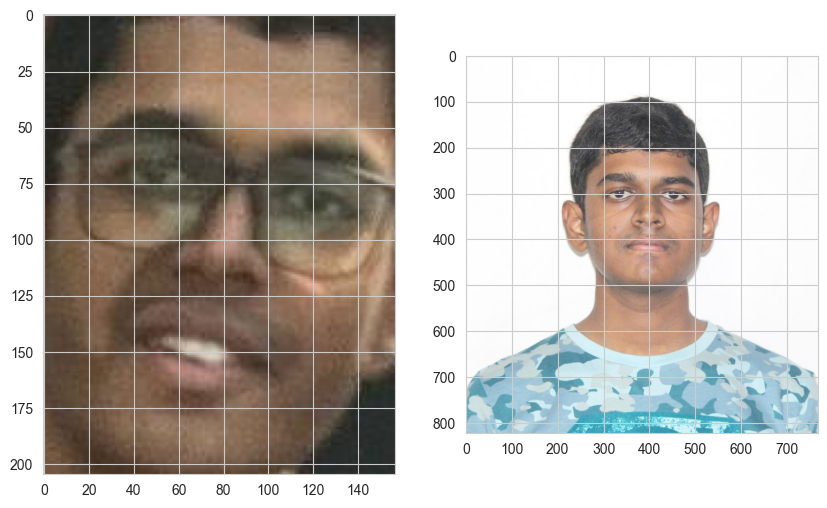

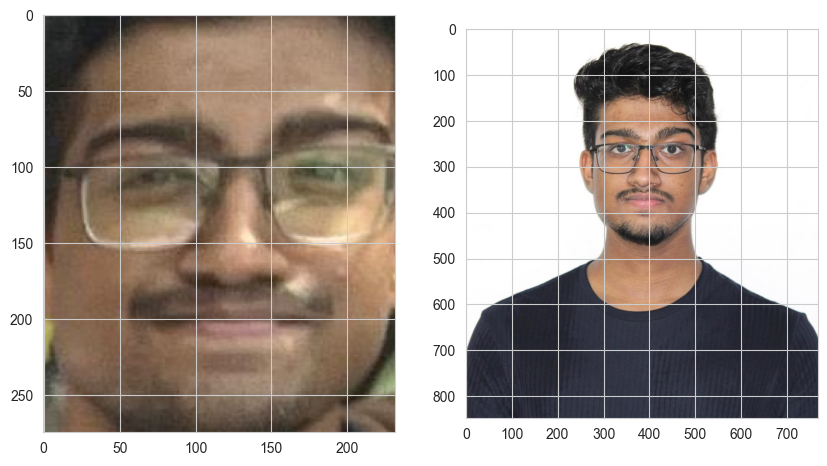

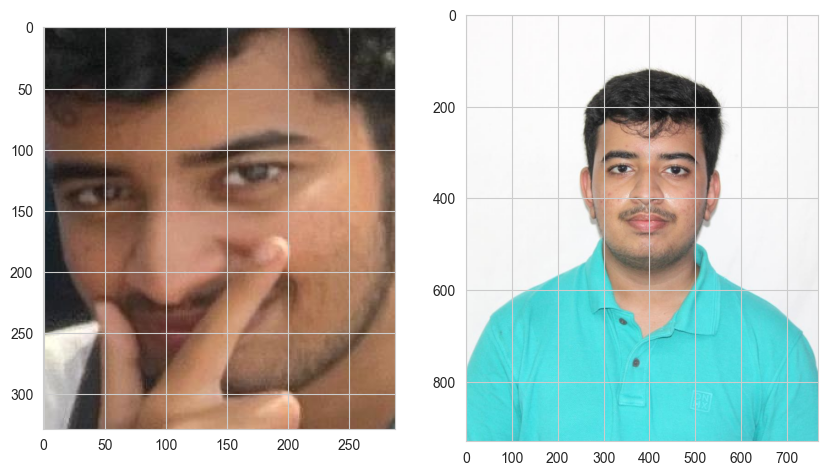

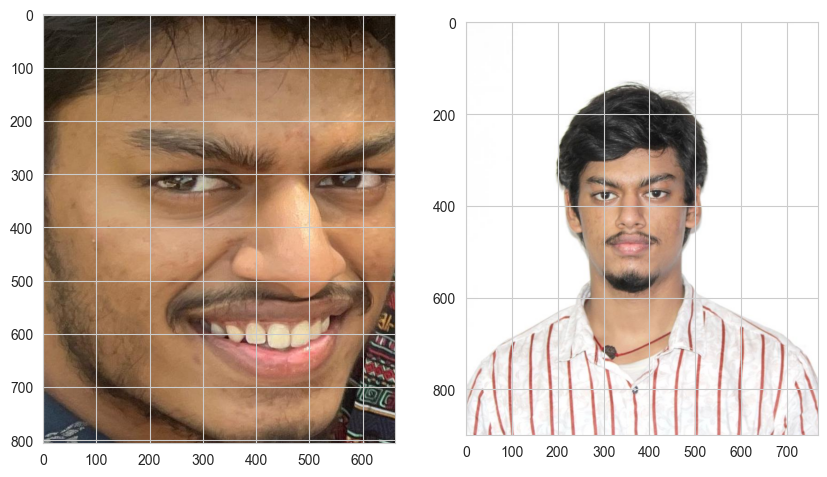

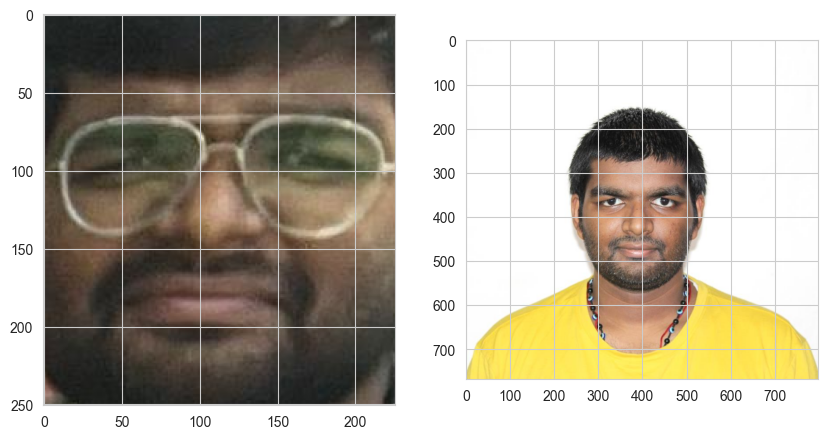

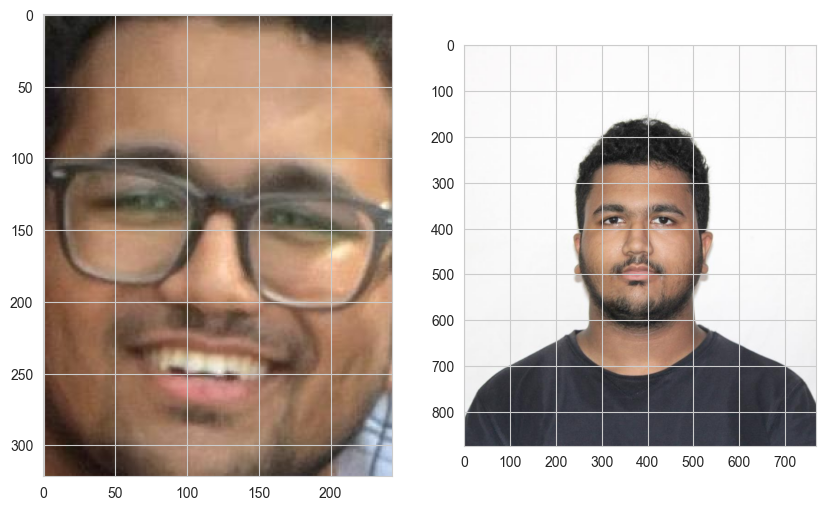

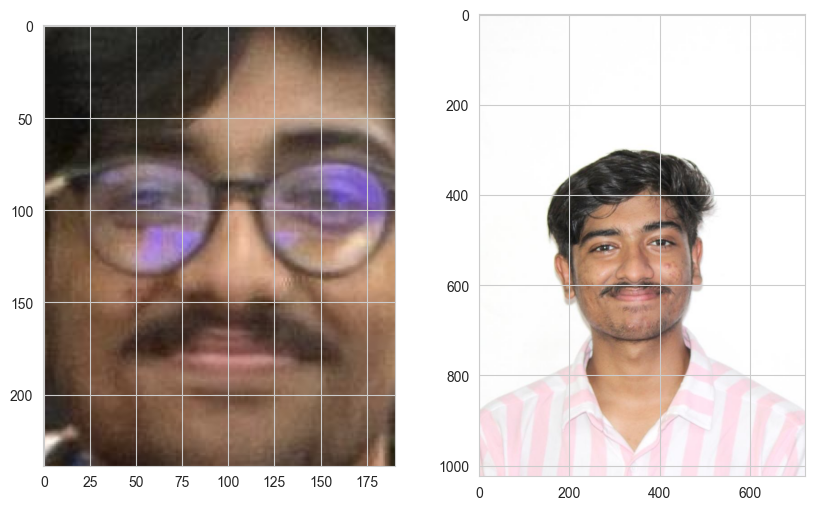

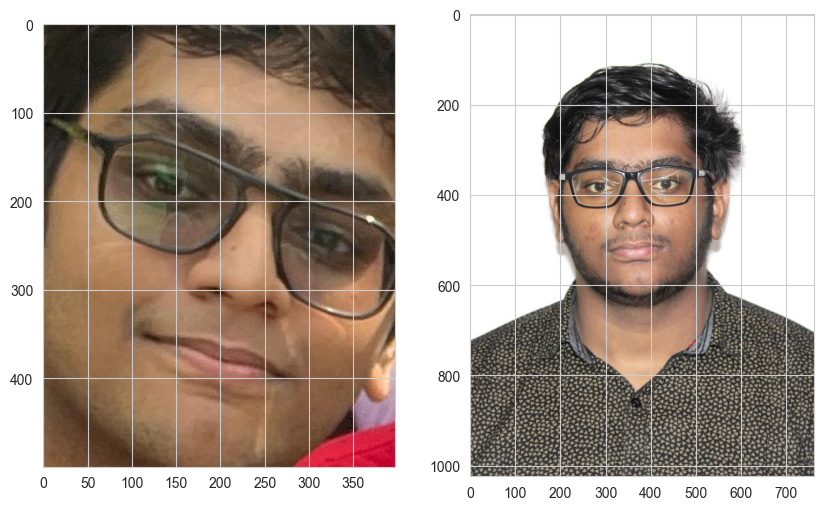

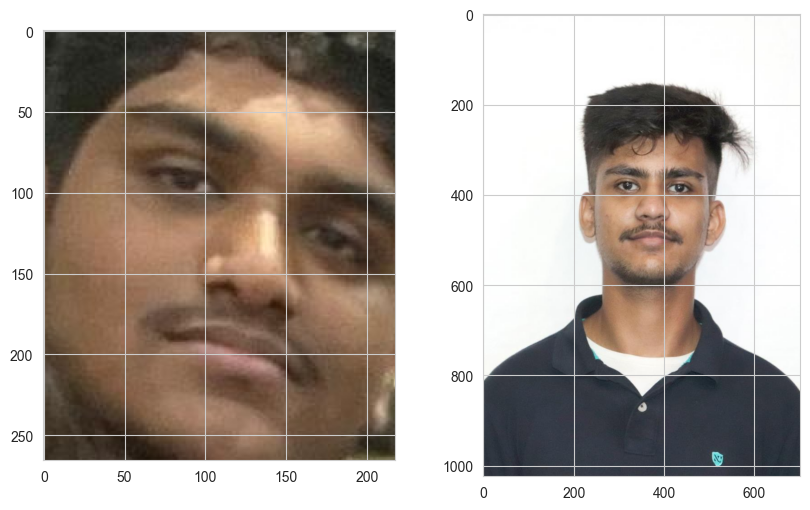

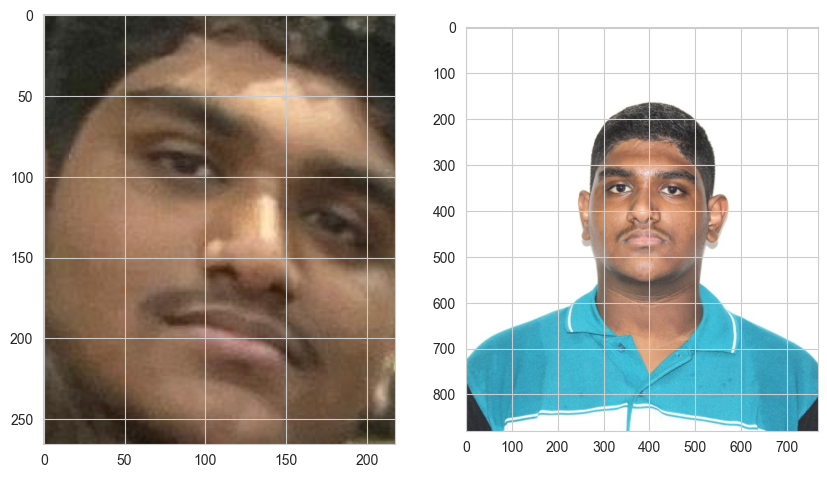

In [77]:
for i in range(len(references)):
    print(f"Iteration {i}")
    calculate_similar(references[i], overall, i, False)

In [ ]:
calculate_similar(test, overall, 56, True)

In [ ]:
torch.save(mtcnn, 'mtcnn.pt')

In [ ]:
torch.save(resnet, 'resnet.pt')

In [ ]:
imgStr = './test_images/outdoors.jpg'
boxes, probs, points = predict_image(imgStr, mtcnn)
show_image(boxes, points, imgStr)

save_piece_wise(boxes, points, imgStr)

classes = return_classes(root_dir)

root_dir = './all_faces'

references = process_reference_images(root_dir, classes)

overall = calculate_face_embedding(imgStr)

# test = calculate_face_embedding('./all_faces/page7_image3.png')

for i in range(len(references)):
    print(f"Iteration {i}")
    calculate_similar(references[i], overall, i, False)